In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from datetime import timedelta
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm
from collections import OrderedDict
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import pickle

In [121]:
def get_cpi():
    cpi = pd.read_excel('data/CPIAUCSL (1).xls')
    #cpi = pd.read_csv("T5YIE.csv")
    cpi.columns = ["date", 'CPI']
    cpi["date"] = pd.to_datetime(cpi["date"]) - timedelta(days=1)
    return cpi
    

def get_stocks():
    stocks = pd.read_csv("data/comp_stocks.csv")
    stocks["datadate"] = pd.to_datetime(stocks["datadate"])
    return stocks


def merge_cpi_stock(stocks, cpi):
    merged = pd.merge(stocks, cpi, how="left", left_on="MthCalDt", right_on="date")
    return merged

def bin_inflation_regimes(cpi, labels = ["deflation","low", "mid", "high"], bins = [-10, 0,1,3,20], value = "CPI", col = "Inflation"):
    cpi[col] = pd.cut(cpi[value],bins, labels=labels)
    return cpi


def get_percent_change(cpi):
    cpi["pct_change"] = cpi["CPI"].pct_change()
    return cpi

# get difference in inflation between two months
def get_inflation_diff(cpi, col = "CPI Diff", value = "CPI"):
    cpi[col] = cpi[value].diff()
    return cpi

def get_forecast():
    forecast = pd.read_csv("data/forecast.csv")
    # string of quarters to months 
    forecast["date"] = pd.to_datetime(forecast["TIME"])
    # sort by date
    forecast = forecast.sort_values(by="date")
    # get duplicate rows in forecast
    forecast[forecast.duplicated(subset=["date"], keep=False)]
    # forecast only for USA
    forecast = forecast[forecast["LOCATION"] == "USA"]

    # remove columns that have same value for all rows
    forecast = forecast.loc[:, forecast.apply(pd.Series.nunique) != 1]

    # remove flag codes columns
    forecast = forecast.loc[:, ~forecast.columns.str.contains('^Flag Codes')]
    return forecast


stocks = get_stocks()
# remove stocks with above 500 trt1m
stocks = stocks[stocks["trt1m"] < 1000]

# remove stocks with below -100 trt1m
stocks = stocks[stocks["trt1m"] > -100]
# drop na gics
stocks = stocks.dropna(subset=["ggroup","gind", "gsector", "gsubind"])
# drop missing trt1m
stocks = stocks.dropna(subset=["trt1m"])

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_4918/1068148022.py:10: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



In [2]:
# read in the saved dict
with open('beta_dict_w_factors_1990_final.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    beta_dict = pickle.load(f)

# read in the saved dict
with open('t_dict_w_factors_1990_final.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    t_dict = pickle.load(f)

In [106]:
beta_df = pd.DataFrame.from_dict(beta_dict, orient="index")

t_df = pd.DataFrame.from_dict(t_dict, orient="index")

# put _t_stat at the end of the t stats
t_df.columns = [col + "_t_stat" for col in t_df.columns]

beta_t_df = pd.merge(beta_df, t_df, how="inner", left_index=True, right_index=True)

beta_t_df = beta_t_df.reset_index()

# rename level_0 to date and level_1 to gvkey
beta_t_df.rename({"level_0": "date", "level_1": "gvkey"}, axis=1, inplace=True)

beta_t_df

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat
0,1984-03-31,1001,1.617369,2.816987,2.802663,-1.072653,-1.026270,1.418310,-6.042002,2.715491,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000
1,1984-06-30,1001,-34.863852,-4.511405,28.574769,-21.044445,21.904572,65.009106,-20.285119,-62.786795,-2.943242,-1.488544,3.021764,-2.850274,3.164111,3.163528,-3.218833,-2.767972
2,1984-09-30,1001,-9.749395,1.823513,1.335508,-0.624966,3.187889,8.838945,0.939543,8.321742,-1.068479,0.915235,0.265933,-0.172691,0.606892,1.234692,0.287985,0.391423
3,1984-12-31,1001,-6.129191,1.606062,1.761768,0.353947,1.459742,4.687031,0.816065,3.462071,-0.805006,0.827017,0.385017,0.103271,0.338221,0.784437,0.299784,0.185480
4,1985-03-31,1001,-0.087791,0.725015,5.974105,0.691378,0.633958,1.776610,-0.793916,1.508161,-0.013529,0.406735,1.669880,0.216568,0.153218,0.373747,-0.356487,0.088519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923648,2022-06-30,351590,-2.024693,2.301945,0.231034,1.831006,4.158512,-1.592552,0.775537,0.173058,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
1923649,2022-09-30,351590,-14.698540,2.770672,14.970408,7.275495,2.357234,4.499387,-0.544222,-119.320140,-7.563526,8.676555,4.763186,7.578787,4.867750,2.962496,-0.765615,-5.012546
1923650,2022-12-31,351590,-3.185057,1.219273,-0.633016,1.428794,1.528512,-0.964526,0.855251,-3.360601,-0.784805,1.935301,-0.285725,1.024656,1.187970,-0.491287,0.465799,-0.310724
1923651,2022-09-30,352257,25.275751,-0.480670,-5.173055,-2.878188,-5.391751,9.997307,-14.732755,-1.171518,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000


In [107]:
saved = beta_t_df.copy()

In [108]:
# shift cpi diff_t_stat by 1
beta_t_df["cpi_diff_t_stat_1_quarter_ago"] = beta_t_df.groupby("gvkey")["CPI Diff_t_stat"].shift(1)
beta_t_df["cpi_diff_t_stat_2_quarter_ago"] = beta_t_df.groupby("gvkey")["CPI Diff_t_stat"].shift(2)
beta_t_df["cpi_diff_t_stat_3_quarter_ago"] = beta_t_df.groupby("gvkey")["CPI Diff_t_stat"].shift(3)
beta_t_df["cpi_diff_t_stat_4_quarter_ago"] = beta_t_df.groupby("gvkey")["CPI Diff_t_stat"].shift(4)

In [166]:
# get sig_stocks that are significant from 1-4 quarters ago
sig_stocks = beta_t_df[(abs(beta_t_df["cpi_diff_t_stat_1_quarter_ago"]) > 2) & (abs(beta_t_df["cpi_diff_t_stat_2_quarter_ago"]) > 2) & (abs(beta_t_df["cpi_diff_t_stat_3_quarter_ago"]) > 2) & (abs(beta_t_df["cpi_diff_t_stat_4_quarter_ago"]) > 2)]


In [167]:
sig_stocks.sort_values(by=["date","gvkey"], inplace=True)

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_4918/268126200.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [168]:
# get stocks past 1990 year
sig_stocks = sig_stocks[sig_stocks["date"] >= "1990-01-01"]

In [169]:
sig_stocks

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,...,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,cpi_diff_t_stat_1_quarter_ago,cpi_diff_t_stat_2_quarter_ago,cpi_diff_t_stat_3_quarter_ago,cpi_diff_t_stat_4_quarter_ago
7295,1990-03-31,1137,3.283759,0.925503,1.288818,-0.906185,-1.281255,-0.885578,0.463565,9.301220,...,1.915523,-0.956630,-1.051794,-0.679853,0.906051,2.487531,2.552418,2.298168,2.247869,2.360296
7857,1990-03-31,1155,1.112289,0.571023,0.757134,-1.672454,-1.729812,0.229824,0.565580,-8.115018,...,1.239602,-1.698296,-1.317870,0.157769,1.148580,-2.185554,-2.290646,-2.053373,-2.036904,-2.045021
11806,1990-03-31,1239,0.048201,1.104216,0.632481,0.090885,-0.042187,0.202424,0.169125,-3.586577,...,2.966837,0.258185,-0.086730,0.406270,0.993556,-2.305625,-2.249599,-2.225591,-2.250183,-2.271983
14804,1990-03-31,1279,0.229285,0.726943,-0.389561,0.711739,-0.166980,-0.467713,-0.129201,-2.063286,...,-3.965071,4.387202,-0.744873,-2.036866,-1.646951,-2.878041,-2.870119,-2.889092,-2.903214,-2.869153
15724,1990-03-31,1300,-0.648277,1.177854,0.169436,0.400530,0.166257,0.333746,0.012307,2.135120,...,1.371126,1.962904,0.589649,1.155566,0.124724,2.367862,2.440329,2.519092,2.636928,2.628982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911866,2022-12-31,272870,-0.829948,1.530586,-0.111183,0.497036,-0.259264,1.254596,0.654325,6.116552,...,-0.181317,0.811883,-0.360631,1.457731,1.504600,1.558806,2.094781,2.061781,2.056218,2.076226
1912433,2022-12-31,273505,-9.937772,1.056945,0.606278,-1.272650,-0.942718,-1.443317,-0.221856,27.226363,...,0.400376,-0.858939,-0.510879,-0.702214,-0.203902,2.773686,2.445334,2.335878,2.266335,2.395090
1915170,2022-12-31,278120,0.960751,0.416485,0.276776,0.019183,0.412291,-0.109489,-0.286955,3.183563,...,1.080283,0.076958,1.309877,-0.283189,-1.990312,2.575319,2.484699,2.526045,2.580400,2.456267
1916045,2022-12-31,279448,-0.064335,0.606795,-0.617795,0.274262,-0.737586,0.305441,-0.534715,4.478439,...,-2.420537,1.091238,-2.330409,0.794468,-3.734313,3.037123,3.822655,3.630973,3.598565,3.680049


In [170]:
sig_stocks_count = sig_stocks.groupby("gvkey").count()

# plot
fig = px.histogram(sig_stocks_count, x="date", nbins=100)
fig.show()

In [171]:
sig_stocks_count

,date,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,...,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,cpi_diff_t_stat_1_quarter_ago,cpi_diff_t_stat_2_quarter_ago,cpi_diff_t_stat_3_quarter_ago,cpi_diff_t_stat_4_quarter_ago
gvkey,,,,,,,,,,,,,,,,,,,,,
1003,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1019,105,105,105,105,105,105,105,105,105,105,...,105,105,105,105,105,105,105,105,105,105
1038,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
1045,108,108,108,108,108,108,108,108,108,108,...,108,108,108,108,108,108,108,108,108,108
1050,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317478,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
325936,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
327589,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [174]:
# get gvkey 220546 in beta_t_df
beta_t_df[(beta_t_df["gvkey"] == 1003) & (abs(beta_t_df["CPI Diff_t_stat"]) > 1.75)]

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,...,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,cpi_diff_t_stat_1_quarter_ago,cpi_diff_t_stat_2_quarter_ago,cpi_diff_t_stat_3_quarter_ago,cpi_diff_t_stat_4_quarter_ago
32,1989-12-31,1003,-0.993408,0.344729,0.672474,-0.275875,-1.271258,-0.613672,-1.179449,-14.109273,...,0.618025,-0.190569,-0.669032,-0.304060,-1.448707,-1.867801,-1.274532,-1.112688,-0.812916,-0.778936
50,1995-06-30,1003,-0.609663,0.195481,0.188297,-0.330705,-1.310380,-0.263797,-0.650193,-7.952773,...,0.329285,-0.422296,-1.260918,-0.212874,-1.422054,-1.760153,-1.743633,-1.726047,-1.730271,-1.706870
51,1995-09-30,1003,-0.616313,0.201726,0.170447,-0.335733,-1.290356,-0.249219,-0.645806,-7.823299,...,0.303381,-0.434413,-1.260532,-0.204075,-1.433607,-1.757508,-1.760153,-1.743633,-1.726047,-1.730271
52,1995-12-31,1003,-0.589380,0.192267,0.151715,-0.364549,-1.285172,-0.221056,-0.623841,-7.849926,...,0.276019,-0.483678,-1.275105,-0.187046,-1.410692,-1.787983,-1.757508,-1.760153,-1.743633,-1.726047
53,1996-03-31,1003,-0.543812,0.189852,0.156007,-0.358936,-1.293920,-0.251240,-0.623531,-7.785746,...,0.289588,-0.487674,-1.303906,-0.221535,-1.432728,-1.806468,-1.787983,-1.757508,-1.760153,-1.743633
54,1996-06-30,1003,-0.617951,0.201119,0.123774,-0.315319,-1.163849,-0.217524,-0.625776,-7.723920,...,0.235707,-0.435468,-1.212638,-0.193966,-1.454538,-1.810863,-1.806468,-1.787983,-1.757508,-1.760153
55,1996-09-30,1003,-0.615227,0.197746,0.110750,-0.282153,-1.076401,-0.207656,-0.631765,-7.754996,...,0.214082,-0.398168,-1.155464,-0.191701,-1.486144,-1.850525,-1.810863,-1.806468,-1.787983,-1.757508
56,1996-12-31,1003,-0.650446,0.220148,0.087032,-0.231779,-1.023011,-0.184911,-0.617883,-7.557212,...,0.173021,-0.333962,-1.118788,-0.173860,-1.484669,-1.840096,-1.850525,-1.810863,-1.806468,-1.787983
57,1997-03-31,1003,-0.638609,0.220259,0.084842,-0.234656,-1.020623,-0.179677,-0.616845,-7.591943,...,0.170943,-0.343764,-1.130742,-0.171925,-1.507550,-1.888881,-1.840096,-1.850525,-1.810863,-1.806468
58,1997-06-30,1003,-0.756024,0.220128,0.047041,-0.203793,-0.952140,-0.160587,-0.564599,-7.644508,...,0.097136,-0.302436,-1.072241,-0.155360,-1.419367,-1.920271,-1.888881,-1.840096,-1.850525,-1.810863


/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_4918/4063754572.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Mkt-RF    0.414636
SMB       0.572109
HML      -0.246881
RMW       0.057393
CMA       0.409941
UMD      -0.326160
dtype: float64

<AxesSubplot:>

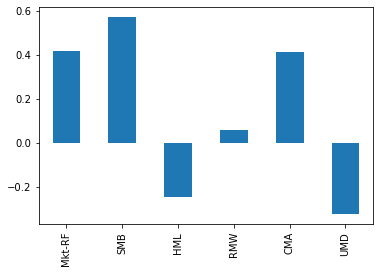

In [162]:
# get average beta for rows with postive CPI Diff_t_stat
mean_factors = sig_stocks[sig_stocks["CPI Diff_t_stat"] > 0].groupby("gvkey").mean().mean()[["Mkt-RF","SMB","HML","RMW","CMA","UMD"]]
display(mean_factors)
# plot
mean_factors.plot(kind="bar")

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_4918/3497492474.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Mkt-RF    0.620137
SMB       0.203233
HML      -0.166498
RMW      -1.297142
CMA      -0.222983
UMD      -0.096384
dtype: float64

<AxesSubplot:>

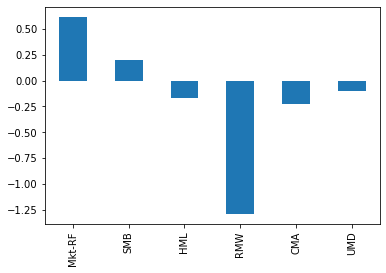

In [163]:
# get average beta for rows with postive CPI Diff_t_stat
mean_factors = sig_stocks[sig_stocks["CPI Diff_t_stat"] < 0].groupby("gvkey").mean().mean()[["Mkt-RF","SMB","HML","RMW","CMA","UMD"]]
display(mean_factors)
# plot
mean_factors.plot(kind="bar")

In [113]:
# get count of stocks per date
sig_stocks_count = sig_stocks.groupby("date").count()

# plot
fig = px.line(sig_stocks_count, x=sig_stocks_count.index, y="gvkey")

fig.show()

In [122]:
stocks.columns

Index(['gvkey', 'iid', 'datadate', 'tic', 'cusip', 'conm', 'dvrate', 'cshtrm',
       'prccm', 'trfm', 'trt1m', 'cshoq', 'cshom', 'exchg', 'cik', 'ggroup',
       'gind', 'gsector', 'gsubind', 'sic', 'spcindcd', 'spcseccd'],
      dtype='object')

In [123]:
# merge sig_stocks with stocks columns that begin with "g"
stocks_industry = stocks[["gvkey","conm", "tic","datadate","ggroup","gind", "gsector", "gsubind"]]

In [124]:
sig_stocks

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,...,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,cpi_diff_t_stat_1_quarter_ago,cpi_diff_t_stat_2_quarter_ago,cpi_diff_t_stat_3_quarter_ago,cpi_diff_t_stat_4_quarter_ago
21917,1990-03-31,1446,-0.927868,0.524596,0.196218,1.073734,-1.025339,-0.280003,1.687987,19.197703,...,0.267759,1.121207,-0.812993,-0.205824,3.046556,3.901264,3.951803,3.945347,3.900069,3.845929
43412,1990-03-31,1848,0.459000,1.064285,-0.528059,-0.112054,-0.343875,0.461133,0.302401,4.000374,...,-3.898843,-0.498510,-1.111313,1.451751,2.806851,4.044768,4.048025,4.011493,3.977589,3.989235
64698,1990-03-31,2226,2.309276,1.411347,0.817756,-0.643925,-2.827371,-2.099835,0.150798,16.391224,...,1.203210,-0.716169,-2.343096,-1.584896,0.285820,3.734216,3.788260,3.934325,3.950379,4.020028
81007,1990-03-31,2535,-0.689340,1.018159,1.012674,-0.016723,-1.444131,0.220815,0.012799,5.416874,...,4.805637,-0.047477,-2.984688,0.442762,0.076473,3.543694,3.541940,3.493190,3.482909,3.529896
97710,1990-03-31,2858,-0.177851,0.711515,-0.221002,0.955509,0.054345,-0.270784,-0.200023,-1.988680,...,-2.443259,6.397339,0.263314,-1.280864,-2.769432,-3.013007,-3.014158,-3.022033,-3.028765,-3.026014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890344,2022-12-31,220546,0.439676,0.845093,0.266871,0.215400,0.198006,0.247483,0.076827,4.819724,...,1.484372,1.184528,0.939792,0.938174,0.726307,5.113133,5.125323,5.109549,5.137379,5.036246
1891582,2022-12-31,221612,0.517452,0.971881,-0.543161,-0.137309,-0.328596,0.398624,-0.235064,4.502429,...,-3.139846,-0.770523,-1.588841,1.527350,-2.392494,4.821081,4.755683,4.600997,4.553785,4.588871
1905733,2022-12-31,264351,0.615902,1.231214,-0.031803,-0.086299,0.010457,0.293874,0.024025,5.685943,...,-0.109749,-0.308140,0.029031,0.679348,0.145494,4.133022,4.407777,4.265555,4.134120,4.000097
1916045,2022-12-31,279448,-0.064335,0.606795,-0.617795,0.274262,-0.737586,0.305441,-0.534715,4.478439,...,-2.420537,1.091238,-2.330409,0.794468,-3.734313,3.037123,3.822655,3.630973,3.598565,3.680049


In [125]:
# merge with sig_stocks
sig_stocks_industry = pd.merge(sig_stocks, stocks_industry, how="left", left_on=["date","gvkey"], right_on=["datadate","gvkey"])

In [130]:
# import gics 
gics = pd.read_csv("data/gics-map-2018.csv")

In [132]:
gics

,SectorId,Sector,IndustryGroupId,IndustryGroup,IndustryId,Industry,SubIndustryId,SubIndustry,SubIndustryDescription
0,10,Energy,1010,Energy,101010,Energy Equipment & Services,10101010,Oil & Gas Drilling,Drilling contractors or owners of drilling rig...
1,10,Energy,1010,Energy,101010,Energy Equipment & Services,10101020,Oil & Gas Equipment & Services,"Manufacturers of equipment, including drilling..."
2,10,Energy,1010,Energy,101020,"Oil, Gas & Consumable Fuels",10102010,Integrated Oil & Gas,Integrated oil companies engaged in the explor...
3,10,Energy,1010,Energy,101020,"Oil, Gas & Consumable Fuels",10102020,Oil & Gas Exploration & Production,Companies engaged in the exploration and produ...
4,10,Energy,1010,Energy,101020,"Oil, Gas & Consumable Fuels",10102030,Oil & Gas Refining & Marketing,Companies engaged in the refining and marketin...
...,...,...,...,...,...,...,...,...,...
153,60,Real Estate,6010,Real Estate,601010,Equity Real Estate Investment Trusts (REITs),60101080,Specialized REITs,Companies or Trusts engaged in the acquisition...
154,60,Real Estate,6010,Real Estate,601020,Real Estate Management & Development,60102010,Diversified Real Estate Activities,Companies engaged in a diverse spectrum of rea...
155,60,Real Estate,6010,Real Estate,601020,Real Estate Management & Development,60102020,Real Estate Operating Companies,Companies engaged in operating real estate pro...
156,60,Real Estate,6010,Real Estate,601020,Real Estate Management & Development,60102030,Real Estate Development,Companies that develop real estate and sell th...


In [133]:
# merge with gics
sig_stocks_industry_names = pd.merge(sig_stocks_industry, gics, how="left", left_on=["gsector","ggroup", "gind", "gsubind"], right_on=["SectorId","IndustryGroupId", "IndustryId", "SubIndustryId"])

In [143]:
sig_stocks_industry_names.columns

Index(['date', 'gvkey', 'const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD',
       'CPI Diff', 'const_t_stat', 'Mkt-RF_t_stat', 'SMB_t_stat', 'HML_t_stat',
       'RMW_t_stat', 'CMA_t_stat', 'UMD_t_stat', 'CPI Diff_t_stat',
       'cpi_diff_t_stat_1_quarter_ago', 'cpi_diff_t_stat_2_quarter_ago',
       'cpi_diff_t_stat_3_quarter_ago', 'cpi_diff_t_stat_4_quarter_ago',
       'conm', 'tic', 'datadate', 'ggroup', 'gind', 'gsector', 'gsubind',
       'SectorId', 'Sector', 'IndustryGroupId', 'IndustryGroup', 'IndustryId',
       'Industry', 'SubIndustryId', 'SubIndustry', 'SubIndustryDescription'],
      dtype='object')

In [153]:
# for positive CPI Diff_t_stat get the industry
display(sig_stocks_industry_names[sig_stocks_industry_names["CPI Diff_t_stat"] > 0].groupby(["Sector", "SectorId"]).count().sort_values(by="gvkey", ascending=False)["date"])
display(sig_stocks_industry_names[sig_stocks_industry_names["CPI Diff_t_stat"] > 0].groupby(["IndustryGroup", "IndustryGroupId"]).count().sort_values(by="gvkey", ascending=False)["date"])

Sector                  SectorId
Energy                  10.0        7401
Materials               15.0        2414
Industrials             20.0         781
Financials              40.0         759
Health Care             35.0         372
Consumer Discretionary  25.0         248
Real Estate             60.0         239
Communication Services  50.0         226
Information Technology  45.0         209
Consumer Staples        30.0         106
Utilities               55.0          59
Name: date, dtype: int64

IndustryGroup                                   IndustryGroupId
Energy                                          1010.0             7401
Materials                                       1510.0             2414
Diversified Financials                          4020.0              535
Capital Goods                                   2010.0              421
Real Estate                                     6010.0              239
Banks                                           4010.0              221
Health Care Equipment & Services                3510.0              186
Pharmaceuticals, Biotechnology & Life Sciences  3520.0              186
Commercial & Professional Services              2020.0              181
Transportation                                  2030.0              179
Consumer Durables & Apparel                     2520.0              179
Media & Entertainment                           5020.0              120
Telecommunication Services                      5010.0              106


In [152]:
# for positive CPI Diff_t_stat get the industry
display(sig_stocks_industry_names[sig_stocks_industry_names["CPI Diff_t_stat"] < 0].groupby(["Sector", "SectorId"]).count().sort_values(by="gvkey", ascending=False)["date"])
display(sig_stocks_industry_names[sig_stocks_industry_names["CPI Diff_t_stat"] < 0].groupby(["IndustryGroup","IndustryGroupId"]).count().sort_values(by="gvkey", ascending=False)["date"])

Sector                  SectorId
Consumer Discretionary  25.0        980
Financials              40.0        888
Utilities               55.0        807
Industrials             20.0        386
Materials               15.0        322
Information Technology  45.0        261
Health Care             35.0        259
Consumer Staples        30.0        205
Energy                  10.0         69
Communication Services  50.0         31
Real Estate             60.0         15
Name: date, dtype: int64

IndustryGroup                                   IndustryGroupId
Utilities                                       5510.0             807
Banks                                           4010.0             710
Retailing                                       2550.0             447
Consumer Durables & Apparel                     2520.0             370
Materials                                       1510.0             322
Capital Goods                                   2010.0             205
Pharmaceuticals, Biotechnology & Life Sciences  3520.0             175
Household & Personal Products                   3030.0             164
Software & Services                             4510.0             159
Diversified Financials                          4020.0             133
Automobiles & Components                        2510.0             128
Commercial & Professional Services              2020.0             105
Technology Hardware & Equipment                 4520.0             100
Health Care E

In [75]:
# get stocks past year 1990
sig_stocks = sig_stocks[sig_stocks["date"] > "1990-01-01"]

In [76]:
sig_stocks

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,CPI_Diff_t_stat_prev
2998,2008-12-31,1062,0.467106,0.366018,0.333575,0.029727,-0.204007,0.058932,0.268648,3.106913,0.935168,3.031560,2.087529,0.123020,-0.908598,0.172263,2.295193,2.581016,2.192758
2999,2009-03-31,1062,0.509026,0.364025,0.329667,0.030496,-0.212859,0.042893,0.258054,3.081364,1.030523,3.069797,2.068886,0.131957,-0.952063,0.126926,2.229797,2.569786,2.581016
3000,2009-06-30,1062,0.614665,0.371314,0.302996,0.055982,-0.224974,-0.015196,0.208299,3.086051,1.243979,3.115816,1.902362,0.240910,-1.004747,-0.044741,1.909075,2.568150,2.569786
3001,2009-09-30,1062,0.627248,0.372963,0.308941,0.051460,-0.211788,-0.010471,0.203538,3.230814,1.273982,3.154334,1.946042,0.222707,-0.951382,-0.030949,1.877293,2.723136,2.568150
3002,2009-12-31,1062,0.612890,0.378561,0.302136,0.062530,-0.227225,-0.011620,0.203652,3.099219,1.249338,3.214671,1.917567,0.271748,-1.026740,-0.034419,1.882220,2.706821,2.723136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923567,2022-06-30,347720,-39.222290,-1.116418,-16.522597,-3.279320,6.997814,-9.603008,7.386351,140.876382,-1.750646,-0.318126,-2.114560,-0.628965,1.408153,-1.372742,1.131847,2.635478,6.613990
1923568,2022-09-30,347720,-22.496186,-0.884010,-14.319533,-2.772748,3.933640,-9.968796,5.309052,126.257995,-1.629537,-0.313362,-2.174169,-0.638167,0.921724,-1.742557,0.951895,2.787157,2.635478
1923587,2022-03-31,348957,-36.340003,5.516808,-4.910893,-1.935302,-0.982686,-1.455992,-1.307761,93.815819,-3.911008,4.132649,-2.400425,-1.353182,-0.686633,-0.601682,-0.501106,5.684175,0.000000
1923588,2022-06-30,348957,-19.447587,1.498327,-2.868176,-1.124910,1.134462,-5.274413,1.034430,60.275572,-2.166844,1.065799,-0.916313,-0.538588,0.569868,-1.882141,0.395690,2.814875,5.684175


In [77]:
# get the count of significant stocks per gvkey
sig_stocks_count = sig_stocks.groupby("gvkey").count()

#plot
fig = px.histogram(sig_stocks_count, x="date", nbins=100)

fig.show()

In [34]:
sig_stocks_count

,date,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat
gvkey,,,,,,,,,,,,,,,,,
1062,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57
1096,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
1121,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
1137,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
1238,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345980,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
347085,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
347720,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [37]:
# get counts over 2 
sig_stocks_count[sig_stocks_count["date"] > 2]

,date,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat
gvkey,,,,,,,,,,,,,,,,,
1062,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57
1096,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
1121,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
1137,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
1238,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315887,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
325867,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
327451,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [ ]:
# get the 